### Result Inspection
This notebook provides an example on how to evaluate trained models by generating trajectories, visualizing the dynamics and evaluating metrics.

In [1]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import seaborn as sns
from bptt.models import Model

In [7]:
data_path = "Experiments/Table1/Lorenz63/data/lorenz63_test.npy"
model_path = "results/Lorenz63/M22B20tau25T200/001/"
#model path had to be modified

In [47]:
data_path = "/home/artur.schneider/Data2Test/datasets/M003_201111_1_kernels10_croped.npy"
data_path = "/home/artur.schneider/Data2Test/datasets/BEHRat480_190823_res30_trafo_Local_norm_1.npy"
model_path = "/home/artur.schneider/dendPLRNN/BPTT_TF/results/TestRunActialData/M75B40tau05T500ModelPLRNN/001/"
model_path = "/home/artur.schneider/dendPLRNN/BPTT_TF/results/TestRunFreiPoseBEHData/M50B40tau05T500ModelPLRNN/001/"
neuraldata = np.load(data_path)
neuraldata.shape

(43200, 36)

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


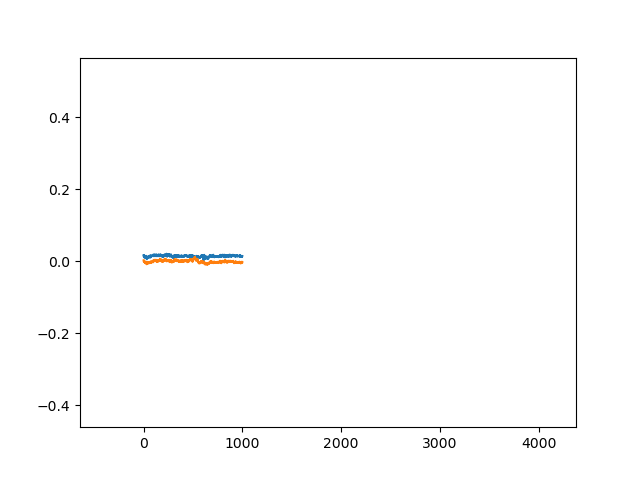

In [48]:
plt.figure()
plt.plot(neuraldata[:1000,0])
plt.plot(neuraldata[:1000,2])

In [49]:
# load data
lor63 = tc.tensor(np.load(data_path))

In [50]:
# restore model checkpoint
m = Model()
m.init_from_model_path(model_path, epoch=2000)
m.eval()
print(repr(m), f"\nNumber of Parameters: {m.get_num_trainable()}")

Chosen model is vanilla PLRNN, the bases Parameter has no effect here!
Model(
  (latent_model): PLRNN(
    (latent_step): PLRNN_Step(
      (norm): Identity()
    )
  )
  (output_layer): Linear(in_features=50, out_features=36, bias=False)
  (z0_model): Z0Model(
    (MLP): Linear(in_features=36, out_features=14, bias=False)
  )
) 
Number of Parameters: 3054


In [38]:
lor63.dtype

torch.float32

In [51]:
T = len(lor63)
X, Z = m.generate_free_trajectory(lor63, T)
X.shape, Z.shape

(torch.Size([43200, 36]), torch.Size([43200, 50]))

In [52]:
# generate a trajectory freely running the model
TestData = tc.tensor(np.load(data_path),dtype=tc.float32)
T = len(TestData)
X, Z = m.generate_free_trajectory(TestData, T)
X.shape, Z.shape

(torch.Size([43200, 36]), torch.Size([43200, 50]))

<IPython.core.display.Javascript object>


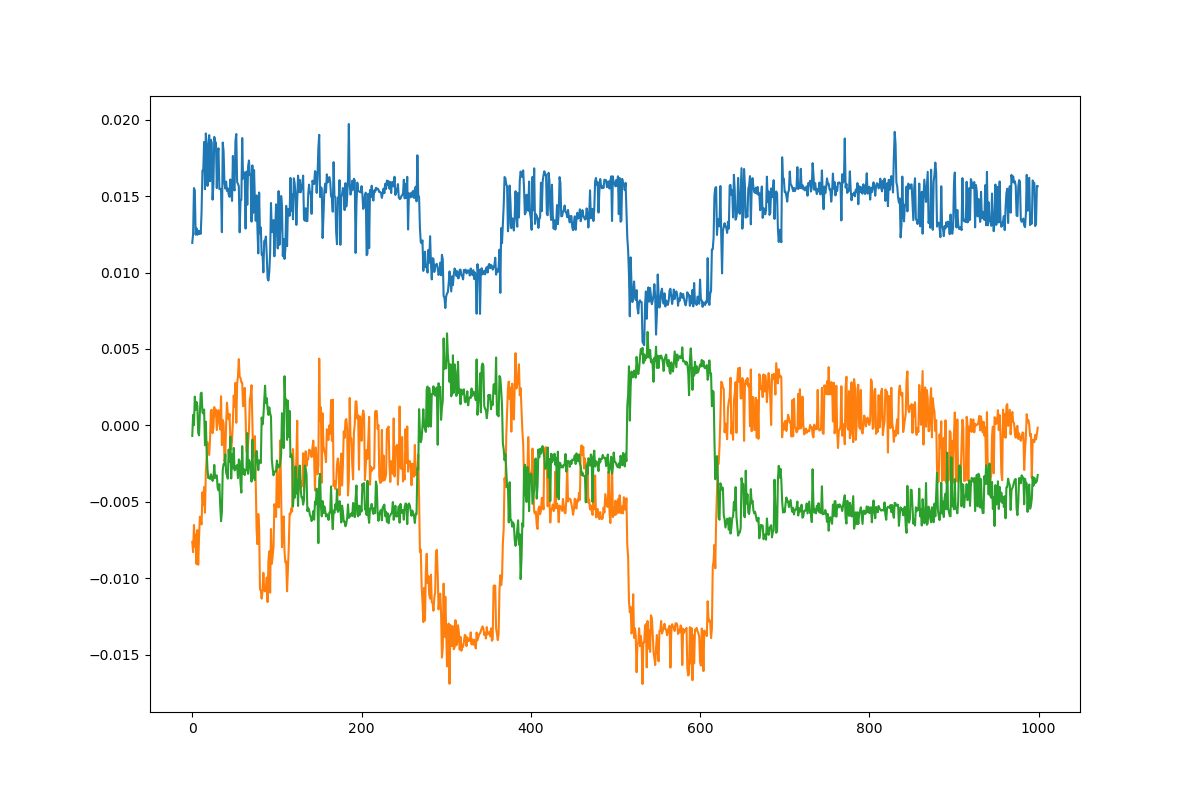

In [53]:
# some plotting
plt.figure(figsize=(12, 8))
plt.plot(TestData[6000:7000,:3])

<IPython.core.display.Javascript object>


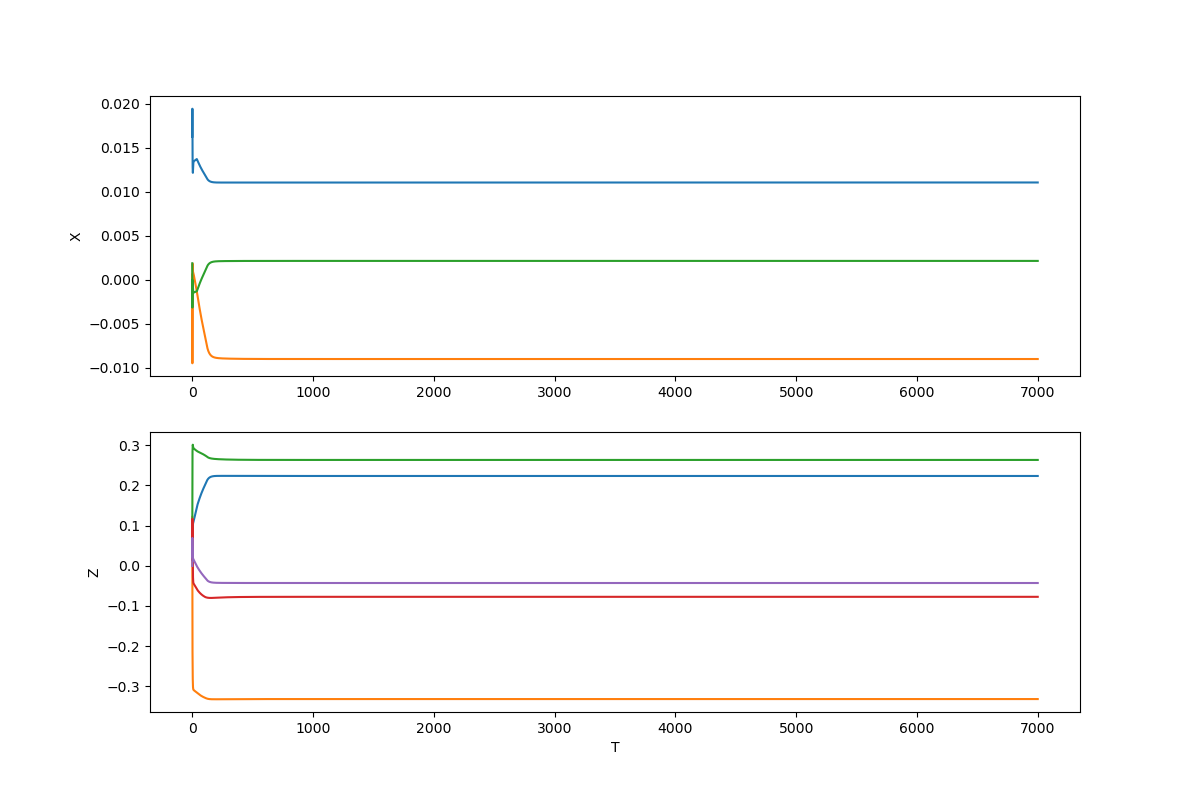

In [54]:
# some plotting
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(X[0:7000,:3])
plt.ylabel("X")
plt.subplot(212)
plt.plot(Z[0:7000, -5:])
plt.ylabel("Z")
plt.xlabel("T")
plt.show()

<IPython.core.display.Javascript object>


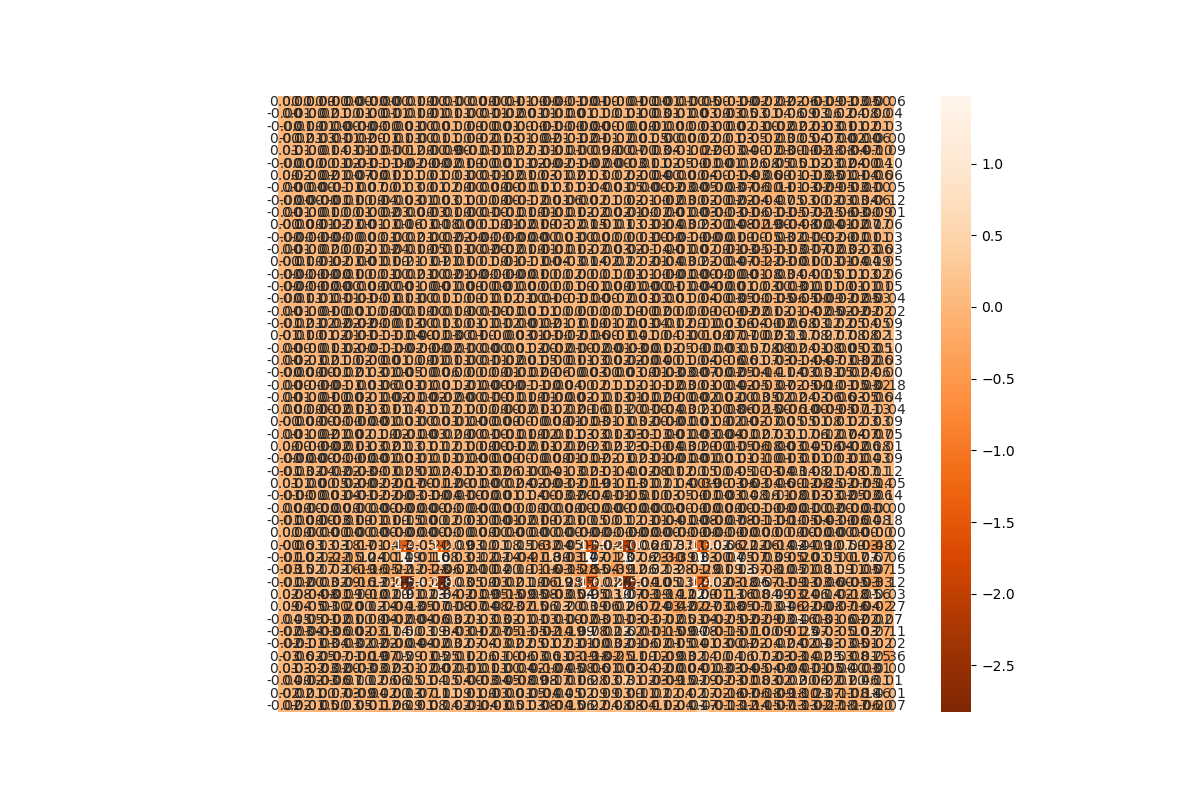

In [55]:
# plot AW matrix
A, W, h = m.latent_model.get_latent_parameters()
AW = tc.diag(A.detach()) + W.detach()
plt.figure(figsize=(12, 8))
sns.heatmap(data=AW, annot=True, cmap="Oranges_r", square=True, fmt='.2f',
            yticklabels=False, xticklabels=False)
plt.show()

<IPython.core.display.Javascript object>


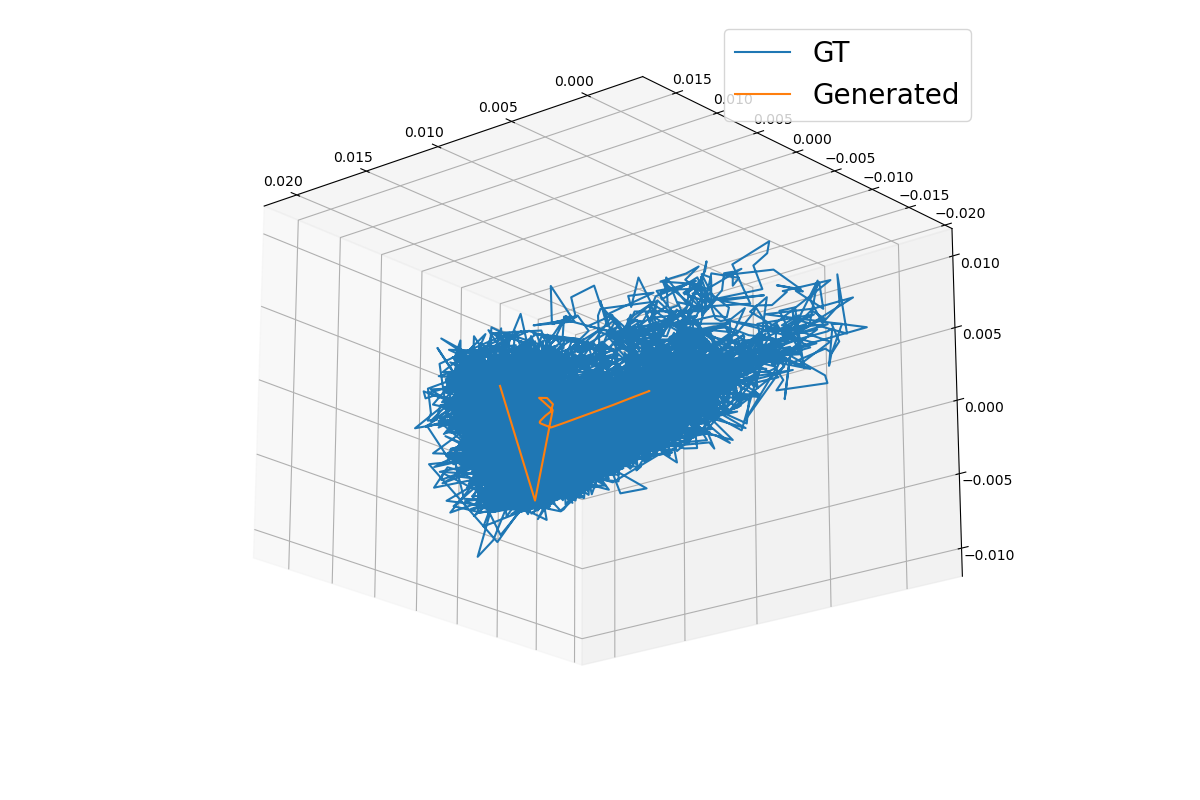

In [56]:
# plot state space trajectories
x_np = Z.numpy()[:10000]
lor_np = lor63.numpy()[:10000]
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.plot3D(lor_np[:, 0], lor_np[:, 1], lor_np[:, 2], label="GT")
ax.plot3D(x_np[:, 0], x_np[:, 1], x_np[:, 2], label="Generated")
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [57]:
# compute KLx and PSE
from evaluation.klx import klx_metric
from evaluation.pse import power_spectrum_error_per_dim

klx = klx_metric(X, lor63, n_bins=30) # evaluated on one long trajectory here!
psc = np.mean(power_spectrum_error_per_dim(X.unsqueeze(0), lor63.unsqueeze(0), 20, 20000))

print(f"KLx = {klx:.3f}, PSC = {psc:.3f}")

RuntimeError: numel: integer multiplication overflow